In [1]:
import os
import re 
import json 
import string 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer,  BertConfig 

import pandas as pd

2024-08-13 10:48:31.909764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 10:48:33.122134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
learning_rate=1e-3 
max_len = 512 
configuration = BertConfig() 
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

save_path = "bert_base_chinese/"
if not os.path.exists(save_path):
     os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path) 



('bert_base_chinese/tokenizer_config.json',
 'bert_base_chinese/special_tokens_map.json',
 'bert_base_chinese/vocab.txt',
 'bert_base_chinese/added_tokens.json')

In [3]:
tokenizer = BertWordPieceTokenizer("bert_base_chinese/vocab.txt", lowercase=True) 


'\n中文文本编码的处理方法如下：\n利用transformers库中的BertTokenizer实现分词编码，实例化一个tokenizer，载入预先下载好的词表，调用encode函数进行编码，encode函数有5个常用参数：\n        ① text： 需要编码的文本；\n        ② add_special_tokens： 是否添加特殊token，即CLS分类token和SEP分隔token；默认True。\n        ③ max_length： 文本的最大长度，根据需要处理的最长文本长度设置；\n        ④ pad_to_max_length： 是否填充到最大长度，以0补位；默认False。\n        ⑤ return_tensors：tensor类型4种[‘pt’, ‘tf’, ‘np’, ‘jax’]即pytorch、tensorflow、int32数组和jax；不指定return_tensors类型则返回列表格式。\n四种tensor类型如下：\n1、pytorch tensor：\ninput_ids:\n tensor([[ 101,  671, 2573, 3299, 5862, 8024,  671, 2573, 6716, 7231, 8024,  671,\n         2573, 1068, 2255, 7410, 3868, 6814,  511, 3470, 6864, 6814, 2145, 8024,\n         2809, 2094, 5442,  679, 7309, 1728, 3362,  511,  102,    0,    0,    0,\n            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,\n            ......\n            0,    0,    0,    0,    0,    0,    0,    0]])\n2、tensorflow tensor：\ninput_ids:\n tf.Tensor(\n[[ 101  671 2573 3299 5862 8024  671 2573 6716 7231 8024  67

In [4]:

df = pd.read_excel('bridge QA 2024.07.25.xlsx')
print(df.head())
print(df.info(),'\n')




def split_data(data, validate_number=20, test_number=6): 
    shuffled_indices = np.random.permutation(len(data))
    test_indices = shuffled_indices[:test_number]
    validate_indices = shuffled_indices[test_number:test_number+validate_number]
    train_indices = shuffled_indices[test_number+validate_number:]
    return data.iloc[train_indices], data.iloc[validate_indices], data.iloc[test_indices]
train_set, validate_set, test_set = split_data(df, validate_number=20, test_number=6) 
print(len(train_set),len(validate_set),len(test_set)) #200，20，6
print( validate_set.head() )


                                             context  \
0  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
1  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
2  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
3  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
4  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   

                       question                                answer  \
0             公路桥涵总体设计时应考虑哪些因素？                    因地制宜、就地取材、便于施工和养护等   
1  公路桥涵在多长时间内应满足规定的正常交通荷载通行的需要？                                设计使用年限   
2             中小桥涵线形设计应该符合什么规定？                             路线设计的总体要求   
3              大桥线形设计应综合考虑哪些因素？  路线总体走向、桥区地质、地形、安全通行、通航、已有建筑设施、环境敏感区等   
4             特大桥线形设计应综合考虑哪些因素？  路线总体走向、桥区地质、地形、安全通行、通航、已有建筑设施、环境敏感区等   

   index_of_answer  number_of_same_answer  
0                0                      1  
1                0                      1  
2                0                      1  
3                0                      1  
4   

"\nprint(train_set.head())\nprint(validate_set.head())\nprint(test_set.head())\nprint(test_set['answer'])\n"

In [5]:
def start_and_end_token_idx(context_ids, answer_ids, index_of_answer):
    answer_ids=answer_ids[1:-1] 
    answer_ids_len=len(answer_ids)
    answer_ids = ' '.join([str(i) for i in answer_ids]) 
    context_ids = ' '.join([str(i) for i in context_ids]) 
    context_ids=context_ids.replace(answer_ids,"#") 
    context_ids=context_ids.split() 

    
    times=0
    for i,value in enumerate(context_ids):
        if value=="#":
            if times==index_of_answer:
                return i+(answer_ids_len-1)*times, i+(answer_ids_len-1)*times+(answer_ids_len-1)     
            times +=1
    


In [6]:
class BridgeExample: 
     def __init__(self, question_text, context_text, answer_text, index_of_answer):
         self.question = question_text
         self.context = context_text
         self.answer = answer_text
         self.index_of_answer = index_of_answer 
         self.skip = False 
     def preprocess(self):
        
         context = " ".join(str(self.context).split())
         question = " ".join(str(self.question).split()) 
         answer = " ".join(str(self.answer).split())

         tokenized_question = tokenizer.encode(question)
         tokenized_context = tokenizer.encode(context)
         tokenized_answer = tokenizer.encode(answer)

         start_token_idx,end_token_idx=start_and_end_token_idx(tokenized_context.ids, tokenized_answer.ids, self.index_of_answer)


         input_ids = tokenized_context.ids + tokenized_question.ids[1:]
         token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:]) #样本
         attention_mask = [1] * len(input_ids) #样本



         padding_length = max_len - len(input_ids)
         if padding_length > 0: 
             input_ids = input_ids + ([0] * padding_length) 
             attention_mask = attention_mask + ([0] * padding_length) 
             token_type_ids = token_type_ids + ([0] * padding_length)
         elif padding_length < 0: 
             self.skip = True
             print("There is an example skip because of padding_length < 0")
             return
         

         self.input_ids = input_ids #样本
         self.token_type_ids = token_type_ids #样本
         self.attention_mask = attention_mask #样本
         self.start_token_idx = start_token_idx #标签
         self.end_token_idx = end_token_idx #标签



In [7]:
def create_bridge_examples(raw_data): 
    bridge_examples = []

    for i in range( len(raw_data["context"]) ):
        context_text = raw_data.iloc[i]["context"] #上下文
        question_text = raw_data.iloc[i]["question"] #问题
        answer_text = raw_data.iloc[i]["answer"] #回答
        index_of_answer = raw_data.iloc[i]["index_of_answer"] 

        bridge_eg = BridgeExample(question_text, context_text, answer_text, index_of_answer)
        bridge_eg.preprocess() 
        bridge_examples.append(bridge_eg)
    return bridge_examples 。

def create_inputs_targets(bridge_examples): 
     dataset_dict = {
         "input_ids": [],#样本的成员
         "token_type_ids": [],#样本的成员
         "attention_mask": [],#样本的成员
         "start_token_idx": [],#标签的成员
         "end_token_idx": [],#标签的成员
     }
     for item in bridge_examples:
         if item.skip == False: #有效样本
             for key in dataset_dict:
                 dataset_dict[key].append(getattr(item, key))

     for key in dataset_dict:
         dataset_dict[key] = np.array(dataset_dict[key])


     x = [ dataset_dict["input_ids"], dataset_dict["token_type_ids"], dataset_dict["attention_mask"] ]#样本
     y = [ dataset_dict["start_token_idx"], dataset_dict["end_token_idx"] ]#标签
     return x, y

In [8]:

train_bridge_examples = create_bridge_examples(train_set) #训练集
x_train, y_train = create_inputs_targets(train_bridge_examples) 
print(f"{len(train_bridge_examples)} training points created.")

eval_bridge_examples = create_bridge_examples(validate_set) #验证集
x_eval, y_eval = create_inputs_targets(eval_bridge_examples)
print(f"{len(eval_bridge_examples)} evaLuation points created.")

test_bridge_examples = create_bridge_examples(test_set) #测试集
x_test, y_test = create_inputs_targets(test_bridge_examples)
print(f"{len(test_bridge_examples)} test points created.")



200 training points created.
20 evaLuation points created.
6 test points created.


'\nprint(len(x_eval)) #len(x_eval)=3\nprint(len(y_eval)) #len(y_eval)=2\n\nx_eval= [array([[ 101, 3565, 4605, ...,    0,    0,    0],\n       [ 101, 3565, 4605, ...,    0,    0,    0],\n       [ 101, 3565, 4605, ...,    0,    0,    0],\n       ...,\n       [ 101, 1996, 9044, ...,    0,    0,    0],\n       [ 101, 1996, 9044, ...,    0,    0,    0],\n       [ 101, 1996, 9044, ...,    0,    0,    0]]), array([[0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       ...,\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0]]), array([[1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       ...,\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0]])]\ny_eval= [array([ 34,  45,  80, ...,  68, 171, 158]), array([ 35,  46,  83, ...,  68, 172, 160])]\n'

In [10]:

os.environ["KERAS_BACKEND"] = "tensorflow" 
import keras
import keras_nlp
print(keras.__version__) #3.4.0
print(keras_nlp.__version__) #0.12.1

def create_model():
     encoder = keras_nlp.models.Backbone.from_preset("bert_base_zh", load_weights=True) 
     encoder.enable_lora(rank=16) 
     input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
     token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
     attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
     embedding = encoder( {"token_ids":input_ids, "segment_ids":token_type_ids, "padding_mask":attention_mask} )
     start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding['sequence_output']) 
     start_logits = layers.Flatten()(start_logits)
     end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding['sequence_output'])
     end_logits = layers.Flatten()(end_logits)
     start_probs = layers.Activation(keras.activations.softmax)(start_logits) 
     end_probs = layers.Activation(keras.activations.softmax)(end_logits)
     model = keras.Model( inputs=[input_ids, token_type_ids, attention_mask], outputs=[start_probs, end_probs] )
     loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
     model.compile(optimizer=optimizer, loss=[loss, loss],metrics=['accuracy','accuracy'] ) 
     return model

3.4.0
0.13.0


In [12]:
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 105,831,1… │ input_layer_2[0]… │
│ (BertBackbone)      │ (None, 512, 768)] │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 512, 1)    │        768 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 512, 1)    │        768 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ start_logit[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ end_logit[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,832,704 (403.72 MB)

 Trainable params: 3,583,488 (13.67 MB)

 Non-trainable params: 102,249,216 (390.05 MB)

In [13]:
class ExactMatch(keras.callbacks.Callback):
     def __init__(self, x_eval, y_eval):
         self.x_eval = x_eval
         self.y_eval = y_eval
     def on_epoch_end(self, epoch, logs=None):
         pred_start, pred_end = self.model.predict(self.x_eval) 
         count = 0
         for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
             start = np.argmax(start) 
             end = np.argmax(end)
             if start == self.y_eval[0][idx] and end == self.y_eval[1][idx]:
                 count += 1 
         acc = count / len(self.y_eval[0])
         print(f"\nepoch={epoch+1}, exact match score={acc:.2f}") 
         #self.model.save_weights('./save_weights/my_model_%03d.weights.h5'%epoch) #每轮均保存模型

In [14]:
def predict_result(x_data, y_data, show=False):
    pred_start, pred_end = model.predict(x_data) 
    count = 0
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        start = np.argmax(start) 
        end = np.argmax(end)
        if start == y_data[0][idx] and end == y_data[1][idx]: 
            count += 1 
    acc = count / len(y_data[0])    
    print('样本数量=',len(y_data[0]))
    print(f"精度={acc:.0%}", "\n") 
    if show:
        for num_of_example in range( len(y_data[0]) ):
            context_AND_question=tokenizer.decode(x_data[0][num_of_example]) 
            label=tokenizer.decode(x_data[0][num_of_example][y_data[0][num_of_example] : y_data[1][num_of_example]+1]) 
            print('label=',y_data[0][num_of_example] , y_data[1][num_of_example],"\n",label)
            answer_start = np.argmax(pred_start[num_of_example])
            answer_end = np.argmax(pred_end[num_of_example])
            label=tokenizer.decode(x_data[0][num_of_example][answer_start : answer_end+1])
            print('预测=',answer_start,answer_end,"\n",label, "\n")

        
predict_result(x_train, y_train, show=False) 
predict_result(x_eval, y_eval, show=False) 
predict_result(x_test, y_test, show=True) #show=True输出标签与预测结果



I0000 00:00:1723517329.075085     754 service.cc:145] XLA service 0x7f7ed00395b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723517329.075143     754 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-13 10:48:49.215922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 10:48:49.558215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step

I0000 00:00:1723517332.721567     754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 987ms/step
样本数量= 200
精度=0% 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
样本数量= 20
精度=0% 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
样本数量= 6
精度=0% 

label= 169 170 
 交 通
预测= 112 11 
  

label= 13 16 
 洪 水 主 流
预测= 5 301 
 3 桥 梁 纵 轴 线 宜 与 洪 水 主 流 流 向 正 交 。 对 通 航 河 流 上 的 桥 梁 ， 其 墩 台 沿 水 流 方 向 的 轴 线 应 与 最 高 通 航 水 位 时 的 主 流 方 向 一 致 。 当 斜 交 不 能 避 免 时 ， 交 角 不 宜 大 于 5° ; 当 交 角 大 于 5° 且 斜 桥 正 做 时 ， 墩 （ 台 ） 边 缘 净 距 宜 按 式 ( 3. 2. 3 ) 计 算 ， 其 计 算 简 图 如 图 3. 2. 3 所 示 。 3. 2. 4 桥 涵 水 文 、 水 力 的 计 算 应 符 合 现 行 《 公 路 工 程 地 质 勘 察 规 范 》 ( jtg c20 ) 和 《 公 路 工 程 水 文 勘 测 设 计 规 范 》 ( jtg c30 ) 的 规 定 。 3. 2. 5 通 航 海 轮 的 桥 梁 布 置 应 满 足 现 行 《 通 航 海 轮 桥 梁 通 航 标 准 》 ( jtj 311 ) 的 规 定 。 通 航 内 河 桥 梁 的 布 置 应 满 足 现 行 《 内 河 通 航 标 准 》 ( gb 50139 ) 的 规 定 ， 并 应 充 分 考 虑 河 床 演 变 和 不 同 通 航 水 位 航 迹 线 的 变 化 。 3. 2. 6 位 于 通 航 水 域 中 的 

label= 196 206 
 不 宜 设 计 成 平 坡 或 凹 曲 线
预测= 212 195 
  

label= 68 69 
 路 堤
预测= 152 273 
 3. 2 小 桥 、 涵 洞 的 孔 径 ， 应 根 据 设 计 洪 水 流 量 、 河 床 地 质 、 河 床 和 锥 坡 加 固 形 式 等 条 件 确 定 ， 并 应 符 合 下 

In [15]:
#history=model.fit( x_train, y_train, epochs=50, batch_size=8, callbacks=[ExactMatch(x_eval, y_eval)])   #采用回调函数的验证集功能，可用设定每轮均保存模型
history=model.fit( x_train, y_train, epochs=50, batch_size=8, validation_data=(x_eval, y_eval) )  #采用keras自身的验证集功能



Epoch 1/50


I0000 00:00:1723517392.297141    1186 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_100', 108 bytes spill stores, 108 bytes spill loads

I0000 00:00:1723517392.777481    1191 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_100', 1112 bytes spill stores, 1260 bytes spill loads

I0000 00:00:1723517393.506873    1188 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_100', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1723517393.705774    1191 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_100', 344 bytes spill stores, 344 bytes spill loads

I0000 00:00:1723517393.767919    1182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_595', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723517394.0807

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - activation_1_accuracy: 0.0415 - activation_accuracy: 0.0218 - loss: 11.5591

I0000 00:00:1723517437.809966    1686 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723517438.126866    1694 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1723517438.871282    1695 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1723517439.007635    1685 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1723517439.108026    1688 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_111', 1216 bytes spill stores, 1232 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 584ms/step - activation_1_accuracy: 0.0432 - activation_accuracy: 0.0233 - loss: 11.5081 - val_activation_1_accuracy: 0.5500 - val_activation_accuracy: 0.4000 - val_loss: 5.0488
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - activation_1_accuracy: 0.4306 - activation_accuracy: 0.5695 - loss: 4.0535 - val_activation_1_accuracy: 0.7500 - val_activation_accuracy: 0.8500 - val_loss: 1.7323
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - activation_1_accuracy: 0.7459 - activation_accuracy: 0.7916 - loss: 1.6258 - val_activation_1_accuracy: 0.8500 - val_activation_accuracy: 0.8500 - val_loss: 0.7679
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - activation_1_accuracy: 0.8679 - activation_accuracy: 0.8838 - loss: 0.8244 - val_activation_1_accuracy: 0.9000 - val_activation_accuracy: 0.8500 - val_loss: 0.9797
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - activation_1_accuracy: 0.9139 - activation_accuracy: 0.9442 - loss: 0.4363 - val_ac

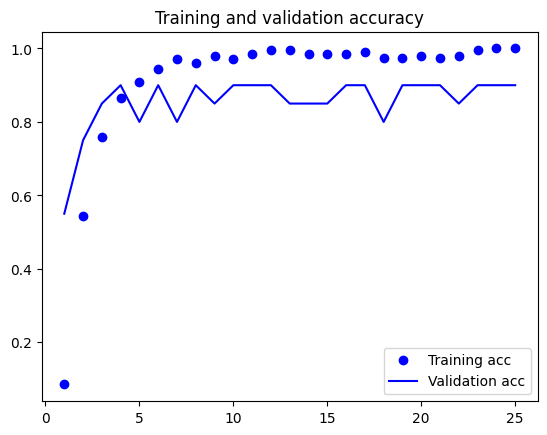

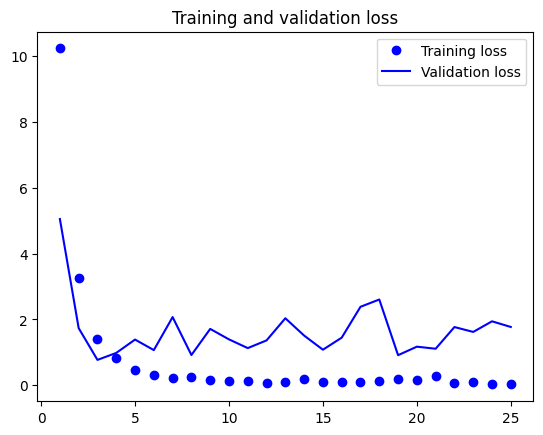

In [20]:

with open(os.path.join('history.txt'), 'w') as file_object:
    file_object.write(str(history.history))

import matplotlib.pyplot as plt
a=25
acc = history.history['activation_1_accuracy'][0:a]
val_acc = history.history['val_activation_1_accuracy'][0:a]
loss = history.history['loss'][0:a]
val_loss = history.history['val_loss'][0:a]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
#用训练集、验证集、测试集的样本，预测
predict_result(x_train, y_train, show=False) 
predict_result(x_eval, y_eval, show=False) 
predict_result(x_test, y_test, show=True) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step
样本数量= 200
精度=100% 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
样本数量= 20
精度=85% 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
样本数量= 6
精度=100% 

label= 169 170 
 交 通
预测= 169 170 
 交 通 

label= 13 16 
 洪 水 主 流
预测= 13 16 
 洪 水 主 流 

label= 196 206 
 不 宜 设 计 成 平 坡 或 凹 曲 线
预测= 196 206 
 不 宜 设 计 成 平 坡 或 凹 曲 线 

label= 68 69 
 路 堤
预测= 68 69 
 路 堤 

label= 136 171 
 路 线 总 体 走 向 、 桥 区 地 质 、 地 形 、 安 全 通 行 、 通 航 、 已 有 建 筑 设 施 、 环 境 敏 感 区 等
预测= 136 171 
 路 线 总 体 走 向 、 桥 区 地 质 、 地 形 、 安 全 通 行 、 通 航 、 已 有 建 筑 设 施 、 环 境 敏 感 区 等 

label= 358 361 
 4. 0m
预测= 358 361 
 4. 0m 

